In [5]:
!pip install earthengine-api geopandas folium matplotlib shapely whiteboxgui geemap tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.6/108.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 26.3 MB/s eta 0:00:00


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project='CLOUD ID')

-------------------FOR RANDOM FOREST REGRESSION-----------------------------------------------


📅 Weekly Temperature Forecast:
2025-04-16 (Wednesday): 32.96°C
2025-04-17 (Thursday): 30.86°C
2025-04-18 (Friday): 27.93°C
2025-04-19 (Saturday): 32.86°C
2025-04-20 (Sunday): 33.92°C
2025-04-21 (Monday): 29.99°C
2025-04-22 (Tuesday): 27.60°C
2025-04-23 (Wednesday): 33.20°C
2025-04-24 (Thursday): 27.73°C
2025-04-25 (Friday): 27.63°C
2025-04-26 (Saturday): 31.66°C
2025-04-27 (Sunday): 31.49°C
2025-04-28 (Monday): 29.24°C
2025-04-29 (Tuesday): 33.31°C


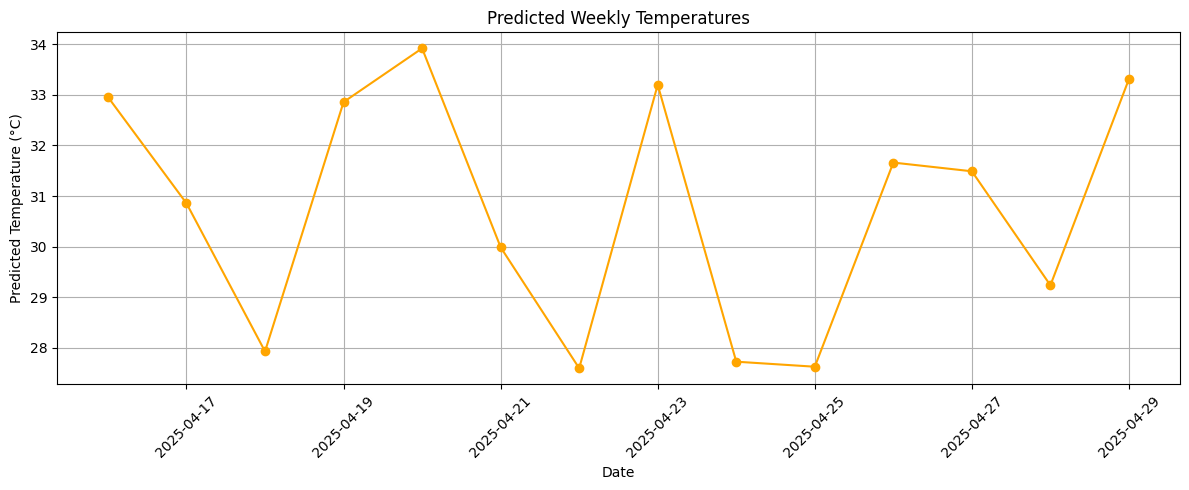

R² (Coefficient of Determination) in Percentage: 81.74%
Mean Absolute Error (MAE) in Percentage: 4.05%
Mean Squared Error (MSE) in Percentage: 1.96
Root Mean Squared Error (RMSE) in Percentage: 4.70%


Map(center=[18.95, 72.99], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
import ee
import geemap
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='CLOUD ID')

# Define AOI
aoi = ee.Geometry.Polygon(
    [[[72.775, 19.250],
      [72.775, 18.850],
      [73.200, 18.850],
      [73.200, 19.250]]])

# Date range
start_date = '2000-01-01'
end_date = '2025-04-15'

# Apply scale factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Cloud masking
def mask_l8sr(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow = (1 << 3)
    clouds = (1 << 5)
    mask = qa.bitwiseAnd(cloud_shadow).eq(0).And(qa.bitwiseAnd(clouds).eq(0))
    return image.updateMask(mask)

# Load Landsat 8 and preprocess
image = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
         .filterDate(start_date, end_date)
         .filterBounds(aoi)
         .map(apply_scale_factors)
         .map(mask_l8sr)
         .mean()
         .clip(aoi))

# NDVI
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
ndvi_stats = ndvi.reduceRegion(ee.Reducer.minMax(), aoi, 150, maxPixels=1e13)
ndvi_min = ee.Number(ndvi_stats.get('NDVI_min'))
ndvi_max = ee.Number(ndvi_stats.get('NDVI_max'))

# FV & Emissivity
fv = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = image.select('ST_B10').rename('thermal')

# LST
lst = thermal.expression(
    '(tb / (1 + ((11.5 * (tb / 14380)) * log(em)))) - 273.15',
    {'tb': thermal.select('thermal'), 'em': em}
).rename('LST')

# Mean, std
lst_mean = ee.Number(lst.reduceRegion(ee.Reducer.mean(), aoi, 150, maxPixels=1e13).get('LST'))
lst_std = ee.Number(lst.reduceRegion(ee.Reducer.stdDev(), aoi, 150, maxPixels=1e13).get('LST'))

# UHI & UTFVI
uhi = lst.subtract(lst_mean).divide(lst_std).rename('UHI')
utfvi = lst.subtract(lst_mean).divide(lst).rename('UTFVI')

# Simulated data
years = np.arange(int(start_date[:4]), int(end_date[:4]) + 1)
df = pd.DataFrame({
    'year': years,
    'temperature_anomaly': np.random.uniform(0, 2, len(years)),
    'vegetation_index': np.random.uniform(0.3, 0.9, len(years)),
    'urban_expansion': np.random.uniform(10, 50, len(years))
})
df['mean_temperature'] = df['temperature_anomaly'] * 5 + 25 + np.random.normal(0, 1, len(df))

# Train model
X = df[['temperature_anomaly', 'vegetation_index', 'urban_expansion']]
y = df['mean_temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Future prediction dates
future_dates = [datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=i) for i in range(1, 15)]
weekdays = [calendar.day_name[date.weekday()] for date in future_dates]
weekly_features = pd.DataFrame({
    'temperature_anomaly': np.random.uniform(0, 2, len(future_dates)),
    'vegetation_index': np.random.uniform(0.3, 0.9, len(future_dates)),
    'urban_expansion': np.random.uniform(10, 50, len(future_dates))
})
weekly_scaled = scaler.transform(weekly_features)
temp_model = RandomForestRegressor(n_estimators=100, random_state=42)
temp_model.fit(X_train_scaled, y_train)
weekly_temp_preds = temp_model.predict(weekly_scaled)

# 📦 Export to CSV & Excel
weekly_output = pd.DataFrame({
    'Date': [d.strftime('%Y-%m-%d') for d in future_dates],
    'Weekday': weekdays,
    'Predicted_Temperature_C': weekly_temp_preds
})
weekly_output.to_csv('weekly_temperature_forecast.csv', index=False)
weekly_output.to_excel('weekly_temperature_forecast.xlsx', index=False)

# 📅 Print forecast
print("\n📅 Weekly Temperature Forecast:")
for date, day, temp in zip(future_dates, weekdays, weekly_temp_preds):
    print(f"{date.strftime('%Y-%m-%d')} ({day}): {temp:.2f}°C")

# 📊 Plot
plt.figure(figsize=(12, 5))
plt.plot(future_dates, weekly_temp_preds, marker='o', linestyle='-', color='orange')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted Weekly Temperatures')
plt.grid(True)
plt.tight_layout()
plt.show()

# Make predictions on the test set
y_pred = temp_model.predict(scaler.transform(X_test))

# Calculate R² (R-squared)
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate Mean of Actual Values (for percentage-based metrics)
mean_actual = np.mean(y_test)

# Convert R² to percentage
r2_percentage = r2 * 100

# Convert MAE to percentage
mae_percentage = (mae / mean_actual) * 100

# Convert RMSE to percentage
rmse_percentage = (rmse / mean_actual) * 100

# Print the evaluation metrics in percentage
print(f"R² (Coefficient of Determination) in Percentage: {r2_percentage:.2f}%")
print(f"Mean Absolute Error (MAE) in Percentage: {mae_percentage:.2f}%")
print(f"Mean Squared Error (MSE) in Percentage: {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) in Percentage: {rmse_percentage:.2f}%")

# Store model metrics
model_name = 'RANDOM FOREST REGRESSION'  # Change this to 'Random Forest', 'SVR', 'LSTM' for each script

metrics_file = 'model_metrics.json'

# Load existing results
if os.path.exists(metrics_file):
    with open(metrics_file, 'r') as f:
        metrics = json.load(f)
else:
    metrics = {}

# Add or update current model
metrics[model_name] = {
    'R2': round(r2 * 100, 2),
    'MAE': round(mae_percentage, 2),
    'RMSE': round(rmse_percentage, 2)
}

# Save back
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=4)

# 🌍 Map
Map = geemap.Map(center=[18.95, 72.99], zoom=10)

Map.addLayer(lst, {
    'min': 25,
    'max': 45,
    'palette': ['green', '#FFFF00', '#FFA500', '#FF4500', 'red']
}, 'LST')

Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')

# ✅ Updated UHI with new color palette
Map.addLayer(uhi, {
    'min': -2,
    'max': 2,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'Urban Heat Island (UHI)')

# ✅ Updated UTFVI with new color palette
Map.addLayer(utfvi, {
    'min': 0,
    'max': 1,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'UTFVI')

# ✅ LST Legend
lst_labels = [
    "Very Hot (Above 40°C)",
    "Hot (35–40°C)",
    "Warm (30–35°C)",
    "Normal (25–30°C)",
    "Cold (Below 25°C)"
]
lst_colors = [
    (255, 0, 0),       # Red
    (255, 165, 0),     # Orange
    (255, 255, 0),     # Yellow
    (0, 128, 0),       # Green
    (0, 0, 255)        # Blue
]
Map.add_legend(title="LST Heatmap Guide", keys=lst_labels, colors=lst_colors, position="topright")

# ✅ Updated UHI Legend
uhi_labels = ["High Urban Heat", "Moderate", "Low Urban Heat", "Cool Area"]
uhi_colors = [
    (255, 0, 0),       # Red
    (255, 165, 0),     # Orange
    (255, 255, 0),     # Yellow
    (0, 128, 0)        # Green
]
Map.add_legend(title="Urban Heat Island (UHI)", keys=uhi_labels, colors=uhi_colors, position="bottomleft")

# ✅ Updated UTFVI Legend
utfvi_labels = ["High Stress", "Moderate", "Low Stress", "Healthy Vegetation"]
utfvi_colors = [
    (255, 0, 0),       # Red
    (255, 165, 0),     # Orange
    (255, 255, 0),     # Yellow
    (0, 128, 0)        # Green
]
Map.add_legend(title="UTFVI Stress Index", keys=utfvi_labels, colors=utfvi_colors, position="bottomright")

# 🗺️ Display the map
Map

-------------------FOR Long Short-Term Memory-----------------------------------------------

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step

📅 Weekly Temperature Forecast:
2025-04-16 (Wednesday): 26.54°C
2025-04-17 (Thursday): 32.41°C
2025-04-18 (Friday): 30.14°C
2025-04-19 (Saturday): 30.82°C
2025-04-20 (Sunday): 29.22°C
2025-04-21 (Monday): 29.54°C
2025-04-22 (Tuesday): 31.87°C
2025-04-23 (Wednesday): 32.11°C
2025-04-24 (Thursday): 33.15°C
2025-04-25 (Friday): 33.60°C
2025-04-26 (Saturday): 30.84°C
2025-04-27 (Sunday): 34.13°C
2025-04-28 (Monday): 31.42°C
2025-04-29 (Tuesday): 27.68°C


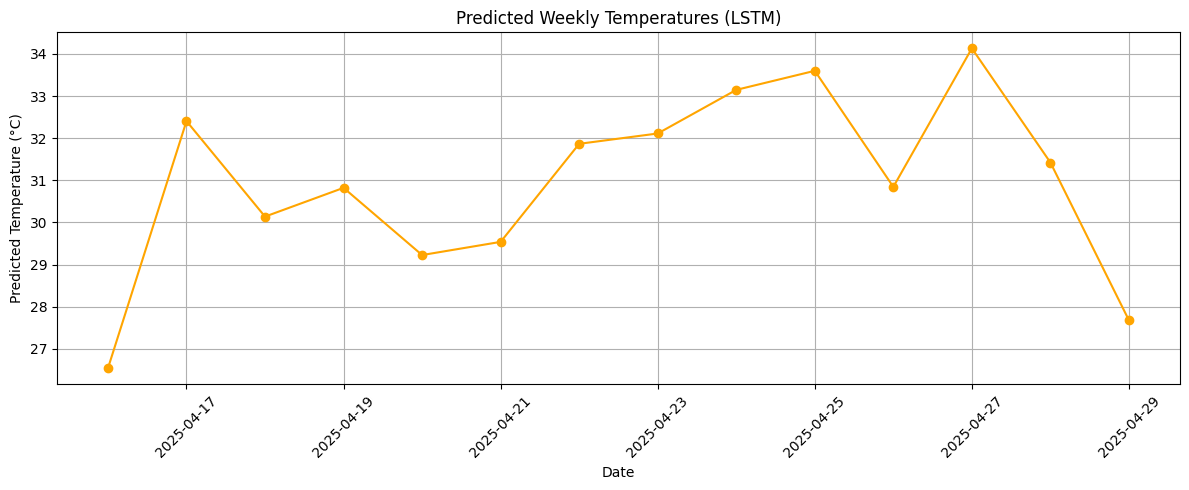

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step

R² (Coefficient of Determination) in Percentage: 74.59%
Mean Absolute Error (MAE) in Percentage: 4.42%
Mean Squared Error (MSE): 1.77
Root Mean Squared Error (RMSE) in Percentage: 4.64%


Map(center=[18.95, 72.99], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
import ee
import geemap
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Earth Engine auth
ee.Authenticate()
ee.Initialize(project='CLOUD ID')

# AOI and dates
aoi = ee.Geometry.Polygon(
    [[[72.775, 19.250], [72.775, 18.850], [73.200, 18.850], [73.200, 19.250]]])
start_date = '2000-01-01'
end_date = '2025-04-15'

# Feature simulation
years = np.arange(int(start_date[:4]), int(end_date[:4]) + 1)
df = pd.DataFrame({
    'year': years,
    'temperature_anomaly': np.random.uniform(0, 2, len(years)),
    'vegetation_index': np.random.uniform(0.3, 0.9, len(years)),
    'urban_expansion': np.random.uniform(10, 50, len(years))
})
df['mean_temperature'] = df['temperature_anomaly'] * 5 + 25 + np.random.normal(0, 1, len(df))

# Feature scaling
X = df[['temperature_anomaly', 'vegetation_index', 'urban_expansion']]
y = df['mean_temperature']
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# LSTM input shape: [samples, time steps, features]
X_lstm = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_scaled, test_size=0.2, random_state=42)

# Model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(1, X.shape[1])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

# Future data (same simulated format)
future_dates = [datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=i) for i in range(1, 15)]
weekdays = [calendar.day_name[date.weekday()] for date in future_dates]
future_features = pd.DataFrame({
    'temperature_anomaly': np.random.uniform(0, 2, len(future_dates)),
    'vegetation_index': np.random.uniform(0.3, 0.9, len(future_dates)),
    'urban_expansion': np.random.uniform(10, 50, len(future_dates))
})
X_future_scaled = scaler_X.transform(future_features)
X_future_lstm = np.reshape(X_future_scaled, (X_future_scaled.shape[0], 1, X_future_scaled.shape[1]))

# Predict
preds_scaled = model.predict(X_future_lstm)
preds = scaler_y.inverse_transform(preds_scaled).flatten()

# Output
weekly_output = pd.DataFrame({
    'Date': [d.strftime('%Y-%m-%d') for d in future_dates],
    'Weekday': weekdays,
    'Predicted_Temperature_C': preds
})
weekly_output.to_csv('weekly_temperature_forecast_lstm.csv', index=False)
weekly_output.to_excel('weekly_temperature_forecast_lstm.xlsx', index=False)

# 📅 Print forecast
print("\n📅 Weekly Temperature Forecast:")
for date, day, temp in zip(future_dates, weekdays, preds):
    print(f"{date.strftime('%Y-%m-%d')} ({day}): {temp:.2f}°C")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(future_dates, preds, marker='o', linestyle='-', color='orange')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted Weekly Temperatures (LSTM)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Model Evaluation
y_test_pred = model.predict(X_test)
y_test_pred_inverse = scaler_y.inverse_transform(y_test_pred)
y_test_true_inverse = scaler_y.inverse_transform(y_test)

r2 = r2_score(y_test_true_inverse, y_test_pred_inverse)
mae = mean_absolute_error(y_test_true_inverse, y_test_pred_inverse)
mse = mean_squared_error(y_test_true_inverse, y_test_pred_inverse)
rmse = np.sqrt(mse)
mean_actual = np.mean(y_test_true_inverse)

# Convert to %
r2_percentage = r2 * 100
mae_percentage = (mae / mean_actual) * 100
rmse_percentage = (rmse / mean_actual) * 100

print(f"\nR² (Coefficient of Determination) in Percentage: {r2_percentage:.2f}%")
print(f"Mean Absolute Error (MAE) in Percentage: {mae_percentage:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) in Percentage: {rmse_percentage:.2f}%")

# Save metrics
model_name = 'LSTM'
metrics_file = 'model_metrics.json'
if os.path.exists(metrics_file):
    with open(metrics_file, 'r') as f:
        metrics = json.load(f)
else:
    metrics = {}

metrics[model_name] = {
    'R2': round(r2_percentage, 2),
    'MAE': round(mae_percentage, 2),
    'RMSE': round(rmse_percentage, 2)
}

with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=4)

# Re-calculate lst, ndvi, uhi, utfvi for the map
# Apply scale factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Cloud masking
def mask_l8sr(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow = (1 << 3)
    clouds = (1 << 5)
    mask = qa.bitwiseAnd(cloud_shadow).eq(0).And(qa.bitwiseAnd(clouds).eq(0))
    return image.updateMask(mask)

# Load Landsat 8 and preprocess
image = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
         .filterDate(start_date, end_date)
         .filterBounds(aoi)
         .map(apply_scale_factors)
         .map(mask_l8sr)
         .mean()
         .clip(aoi))

# NDVI
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
ndvi_stats = ndvi.reduceRegion(ee.Reducer.minMax(), aoi, 150, maxPixels=1e13)
ndvi_min = ee.Number(ndvi_stats.get('NDVI_min'))
ndvi_max = ee.Number(ndvi_stats.get('NDVI_max'))

# FV & Emissivity
fv = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = image.select('ST_B10').rename('thermal')

# LST
lst = thermal.expression(
    '(tb / (1 + ((11.5 * (tb / 14380)) * log(em)))) - 273.15',
    {'tb': thermal.select('thermal'), 'em': em}
).rename('LST')

# Mean, std
lst_mean = ee.Number(lst.reduceRegion(ee.Reducer.mean(), aoi, 150, maxPixels=1e13).get('LST'))
lst_std = ee.Number(lst.reduceRegion(ee.Reducer.stdDev(), aoi, 150, maxPixels=1e13).get('LST'))

# UHI & UTFVI
uhi = lst.subtract(lst_mean).divide(lst_std).rename('UHI')
utfvi = lst.subtract(lst_mean).divide(lst).rename('UTFVI')

# Map
Map = geemap.Map(center=[18.95, 72.99], zoom=10)
Map.addLayer(lst, {
    'min': 25,
    'max': 45,
    'palette': ['green', '#FFFF00', '#FFA500', '#FF4500', 'red']
}, 'LST')
Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
Map.addLayer(uhi, {
    'min': -2,
    'max': 2,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'Urban Heat Island (UHI)')
Map.addLayer(utfvi, {
    'min': 0,
    'max': 1,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'UTFVI')

lst_labels = ["Very Hot (Above 40°C)", "Hot (35–40°C)", "Warm (30–35°C)", "Normal (25–30°C)", "Cold (Below 25°C)"]
lst_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0), (0, 0, 255)]
Map.add_legend(title="LST Heatmap Guide", keys=lst_labels, colors=lst_colors, position="topright")

uhi_labels = ["High Urban Heat", "Moderate", "Low Urban Heat", "Cool Area"]
uhu_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0)]
Map.add_legend(title="Urban Heat Island (UHI)", keys=uhi_labels, colors=uhu_colors, position="bottomleft")

utfvi_labels = ["High Stress", "Moderate", "Low Stress", "Healthy Vegetation"]
utfvi_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0)]
Map.add_legend(title="UTFVI Stress Index", keys=utfvi_labels, colors=utfvi_colors, position="bottomright")

Map


-------------------FOR Support Vector Regression-----------------------------------------------

🔍 Improved SVR Accuracy Metrics:
R² (Coefficient of Determination) in Percentage: 51.35%
Mean Absolute Error (MAE) in Percentage: 4.75%
Mean Squared Error (MSE): 3.62
Root Mean Squared Error (RMSE) in Percentage: 6.05%

📅 Weekly Temperature Forecast (SVR):
2025-04-16 (Wednesday): 33.28°C
2025-04-17 (Thursday): 29.87°C
2025-04-18 (Friday): 26.70°C
2025-04-19 (Saturday): 34.95°C
2025-04-20 (Sunday): 28.32°C
2025-04-21 (Monday): 30.87°C
2025-04-22 (Tuesday): 28.07°C
2025-04-23 (Wednesday): 34.23°C
2025-04-24 (Thursday): 30.97°C
2025-04-25 (Friday): 32.41°C
2025-04-26 (Saturday): 26.41°C
2025-04-27 (Sunday): 27.20°C
2025-04-28 (Monday): 30.29°C
2025-04-29 (Tuesday): 26.36°C


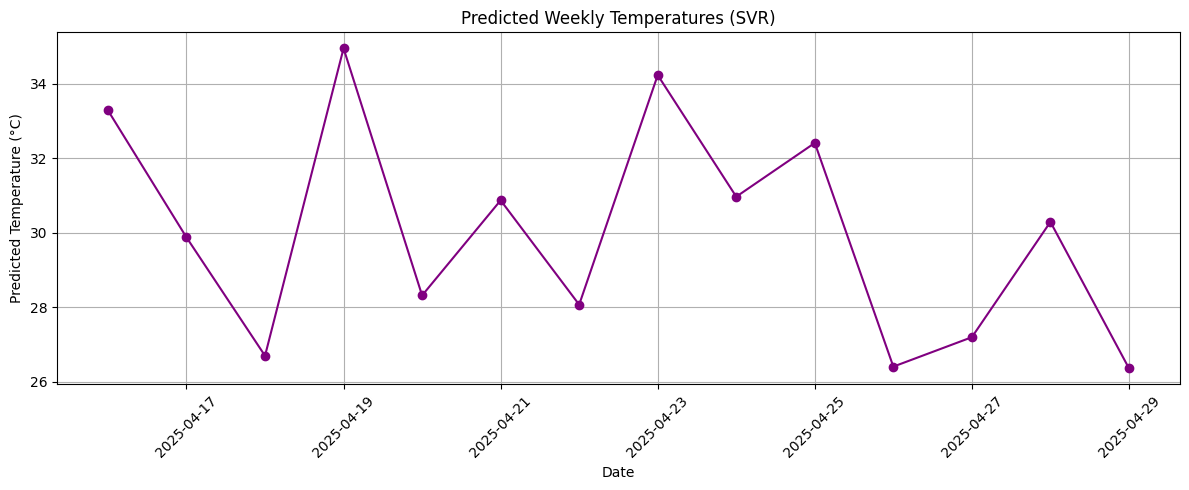

Map(center=[18.95, 72.99], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
import ee
import geemap
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='CLOUD ID')

# Define AOI
aoi = ee.Geometry.Polygon(
    [[[72.775, 19.250],
      [72.775, 18.850],
      [73.200, 18.850],
      [73.200, 19.250]]])

# Date range
start_date = '2000-01-01'
end_date = '2025-04-15'

# Apply scale factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Cloud masking
def mask_l8sr(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow = (1 << 3)
    clouds = (1 << 5)
    mask = qa.bitwiseAnd(cloud_shadow).eq(0).And(qa.bitwiseAnd(clouds).eq(0))
    return image.updateMask(mask)

# Load Landsat 8 and preprocess
image = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
         .filterDate(start_date, end_date)
         .filterBounds(aoi)
         .map(apply_scale_factors)
         .map(mask_l8sr)
         .mean()
         .clip(aoi))

# NDVI
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
ndvi_stats = ndvi.reduceRegion(ee.Reducer.minMax(), aoi, 150, maxPixels=1e13)
ndvi_min = ee.Number(ndvi_stats.get('NDVI_min'))
ndvi_max = ee.Number(ndvi_stats.get('NDVI_max'))

# FV & Emissivity
fv = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = image.select('ST_B10').rename('thermal')

# LST
lst = thermal.expression(
    '(tb / (1 + ((11.5 * (tb / 14380)) * log(em)))) - 273.15',
    {'tb': thermal.select('thermal'), 'em': em}
).rename('LST')

# Mean, std
lst_mean = ee.Number(lst.reduceRegion(ee.Reducer.mean(), aoi, 150, maxPixels=1e13).get('LST'))
lst_std = ee.Number(lst.reduceRegion(ee.Reducer.stdDev(), aoi, 150, maxPixels=1e13).get('LST'))

# UHI & UTFVI
uhi = lst.subtract(lst_mean).divide(lst_std).rename('UHI')
utfvi = lst.subtract(lst_mean).divide(lst).rename('UTFVI')

# Simulated data
years = np.arange(int(start_date[:4]), int(end_date[:4]) + 1)
df = pd.DataFrame({
    'year': years,
    'temperature_anomaly': np.random.uniform(0, 2, len(years)),
    'vegetation_index': np.random.uniform(0.3, 0.9, len(years)),
    'urban_expansion': np.random.uniform(10, 50, len(years))
})
df['mean_temperature'] = df['temperature_anomaly'] * 5 + 25 + np.random.normal(0, 1, len(df))

# Feature selection
X = df[['temperature_anomaly', 'vegetation_index', 'urban_expansion']]
y = df['mean_temperature']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning
param_grid = {
    'C': [10, 100, 1000],
    'gamma': [0.01, 0.1, 1],
    'epsilon': [0.01, 0.1, 0.5]
}
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)
best_svr = grid_search.best_estimator_

# Predict
y_pred = best_svr.predict(X_test_scaled)

# Evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mean_actual = np.mean(y_test)
r2_percentage = r2 * 100
mae_percentage = (mae / mean_actual) * 100
rmse_percentage = (rmse / mean_actual) * 100

print(f"🔍 Improved SVR Accuracy Metrics:")
print(f"R² (Coefficient of Determination) in Percentage: {r2_percentage:.2f}%")
print(f"Mean Absolute Error (MAE) in Percentage: {mae_percentage:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) in Percentage: {rmse_percentage:.2f}%")

# Store model metrics
model_name = 'Support Vector Regression'  # Change this to 'Random Forest', 'SVR', 'LSTM' for each script

metrics_file = 'model_metrics.json'

# Load existing results
if os.path.exists(metrics_file):
    with open(metrics_file, 'r') as f:
        metrics = json.load(f)
else:
    metrics = {}

# Add or update current model
metrics[model_name] = {
    'R2': round(r2 * 100, 2),
    'MAE': round(mae_percentage, 2),
    'RMSE': round(rmse_percentage, 2)
}

# Save back
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=4)

# Future prediction dates
future_dates = [datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=i) for i in range(1, 15)]
weekdays = [calendar.day_name[date.weekday()] for date in future_dates]

# Simulated future features
future_features = pd.DataFrame({
    'temperature_anomaly': np.random.uniform(0, 2, len(future_dates)),
    'vegetation_index': np.random.uniform(0.3, 0.9, len(future_dates)),
    'urban_expansion': np.random.uniform(10, 50, len(future_dates))
})

future_scaled = scaler.transform(future_features)
future_predictions = best_svr.predict(future_scaled)

forecast_df = pd.DataFrame({
    'Date': [d.strftime('%Y-%m-%d') for d in future_dates],
    'Weekday': weekdays,
    'Predicted_Temperature_C': future_predictions
})
forecast_df.to_csv("weekly_temperature_forecast_svr_improved.csv", index=False)
forecast_df.to_excel("weekly_temperature_forecast_svr_improved.xlsx", index=False)

print("\n📅 Weekly Temperature Forecast (SVR):")
for d, day, temp in zip(future_dates, weekdays, future_predictions):
    print(f"{d.strftime('%Y-%m-%d')} ({day}): {temp:.2f}°C")

plt.figure(figsize=(12, 5))
plt.plot(future_dates, future_predictions, marker='o', linestyle='-', color='purple')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted Weekly Temperatures (SVR)')
plt.grid(True)
plt.tight_layout()
plt.show()

# 🌍 Map
Map = geemap.Map(center=[18.95, 72.99], zoom=10)
Map.addLayer(lst, {
    'min': 25,
    'max': 45,
    'palette': ['green', '#FFFF00', '#FFA500', '#FF4500', 'red']
}, 'LST')

Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
Map.addLayer(uhi, {
    'min': -2,
    'max': 2,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'Urban Heat Island (UHI)')
Map.addLayer(utfvi, {
    'min': 0,
    'max': 1,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'UTFVI')

lst_labels = ["Very Hot (Above 40°C)", "Hot (35–40°C)", "Warm (30–35°C)", "Normal (25–30°C)", "Cold (Below 25°C)"]
lst_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0), (0, 0, 255)]
Map.add_legend(title="LST Heatmap Guide", keys=lst_labels, colors=lst_colors, position="topright")

uhi_labels = ["High Urban Heat", "Moderate", "Low Urban Heat", "Cool Area"]
uhi_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0)]
Map.add_legend(title="Urban Heat Island (UHI)", keys=uhi_labels, colors=uhi_colors, position="bottomleft")

utfvi_labels = ["High Stress", "Moderate", "Low Stress", "Healthy Vegetation"]
utfvi_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0)]
Map.add_legend(title="UTFVI Stress Index", keys=utfvi_labels, colors=utfvi_colors, position="bottomright")

Map

-------------------FOR XGBoost (XGBRegressor)-----------------------------------------------


📅 Weekly Temperature Forecast:
2025-04-16 (Wednesday): 34.21°C
2025-04-17 (Thursday): 31.76°C
2025-04-18 (Friday): 31.25°C
2025-04-19 (Saturday): 37.26°C
2025-04-20 (Sunday): 31.76°C
2025-04-21 (Monday): 34.13°C
2025-04-22 (Tuesday): 31.65°C
2025-04-23 (Wednesday): 31.55°C
2025-04-24 (Thursday): 33.30°C
2025-04-25 (Friday): 31.13°C
2025-04-26 (Saturday): 31.76°C
2025-04-27 (Sunday): 29.17°C
2025-04-28 (Monday): 33.79°C
2025-04-29 (Tuesday): 33.15°C


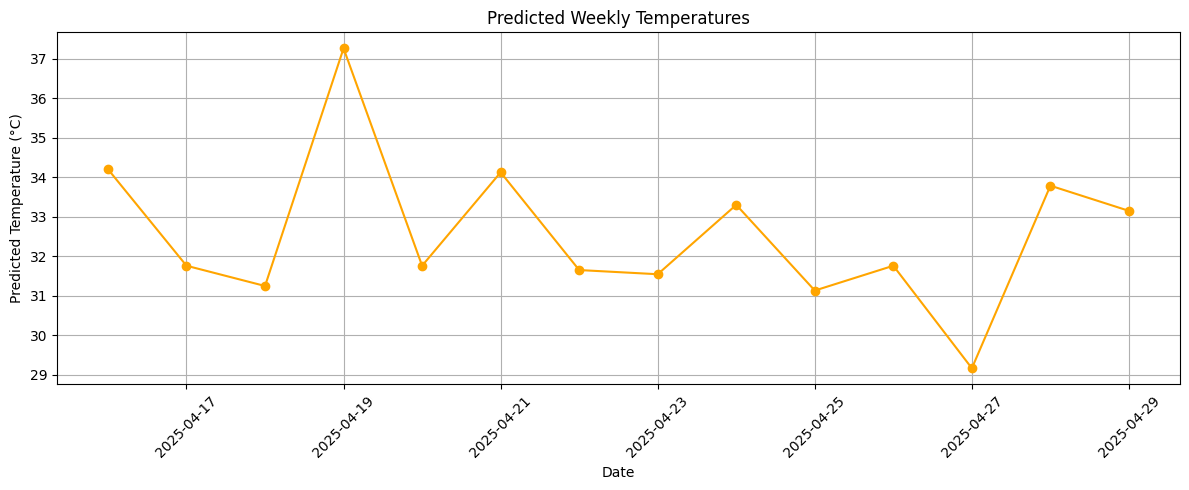

R² (Coefficient of Determination) in Percentage: 97.57%
Mean Absolute Error (MAE) in Percentage: 1.20%
Mean Squared Error (MSE): 0.30
Root Mean Squared Error (RMSE) in Percentage: 1.63%


Map(center=[18.95, 72.99], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

In [ ]:
import ee
import geemap
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import calendar
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='CLOUD ID')

# Define AOI
aoi = ee.Geometry.Polygon(
    [[[72.775, 19.250],
      [72.775, 18.850],
      [73.200, 18.850],
      [73.200, 19.250]]])

# Date range
start_date = '2000-01-01'
end_date = '2025-04-15'

# Apply scale factors
def apply_scale_factors(image):
    optical_bands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermal_bands = image.select('ST_B.*').multiply(0.00341802).add(149.0)
    return image.addBands(optical_bands, None, True).addBands(thermal_bands, None, True)

# Cloud masking
def mask_l8sr(image):
    qa = image.select('QA_PIXEL')
    cloud_shadow = (1 << 3)
    clouds = (1 << 5)
    mask = qa.bitwiseAnd(cloud_shadow).eq(0).And(qa.bitwiseAnd(clouds).eq(0))
    return image.updateMask(mask)

# Load Landsat 8 and preprocess
image = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')
         .filterDate(start_date, end_date)
         .filterBounds(aoi)
         .map(apply_scale_factors)
         .map(mask_l8sr)
         .mean()
         .clip(aoi))

# NDVI
ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
ndvi_stats = ndvi.reduceRegion(ee.Reducer.minMax(), aoi, 150, maxPixels=1e13)
ndvi_min = ee.Number(ndvi_stats.get('NDVI_min'))
ndvi_max = ee.Number(ndvi_stats.get('NDVI_max'))

# FV & Emissivity
fv = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).pow(2).rename('FV')
em = fv.multiply(0.004).add(0.986).rename('EM')
thermal = image.select('ST_B10').rename('thermal')

# LST
lst = thermal.expression(
    '(tb / (1 + ((11.5 * (tb / 14380)) * log(em)))) - 273.15',
    {'tb': thermal.select('thermal'), 'em': em}
).rename('LST')

# Mean, std
lst_mean = ee.Number(lst.reduceRegion(ee.Reducer.mean(), aoi, 150, maxPixels=1e13).get('LST'))
lst_std = ee.Number(lst.reduceRegion(ee.Reducer.stdDev(), aoi, 150, maxPixels=1e13).get('LST'))

# UHI & UTFVI
uhi = lst.subtract(lst_mean).divide(lst_std).rename('UHI')
utfvi = lst.subtract(lst_mean).divide(lst).rename('UTFVI')

# Simulated data
years = np.arange(int(start_date[:4]), int(end_date[:4]) + 1)
df = pd.DataFrame({'year': years})
np.random.seed(42)
df['temperature_anomaly'] = np.linspace(0.2, 2, len(df)) + np.random.normal(0, 0.1, len(df))
df['vegetation_index'] = 0.9 - df['temperature_anomaly'] * 0.2 + np.random.normal(0, 0.02, len(df))
df['urban_expansion'] = 30 + df['temperature_anomaly'] * 10 + np.random.normal(0, 2, len(df))
df['mean_temperature'] = 25 + df['temperature_anomaly'] * 6 - df['vegetation_index'] * 2 + \
                         df['urban_expansion'] * 0.1 + np.random.normal(0, 0.8, len(df))

# Polynomial features
X = df[['temperature_anomaly', 'vegetation_index', 'urban_expansion']]
y = df['mean_temperature']
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
temp_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    early_stopping_rounds=10,
    objective='reg:squarederror'
)
temp_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

# Predict weekly
future_dates = [datetime.strptime(end_date, "%Y-%m-%d") + timedelta(days=i) for i in range(1, 15)]
weekdays = [calendar.day_name[date.weekday()] for date in future_dates]
weekly_features = pd.DataFrame({
    'temperature_anomaly': np.random.uniform(0, 2, len(future_dates)),
    'vegetation_index': np.random.uniform(0.3, 0.9, len(future_dates)),
    'urban_expansion': np.random.uniform(10, 50, len(future_dates))
})
weekly_poly = poly.transform(weekly_features)
weekly_scaled = scaler.transform(weekly_poly)
weekly_temp_preds = temp_model.predict(weekly_scaled)

# Export
weekly_output = pd.DataFrame({
    'Date': [d.strftime('%Y-%m-%d') for d in future_dates],
    'Weekday': weekdays,
    'Predicted_Temperature_C': weekly_temp_preds
})
weekly_output.to_csv('weekly_temperature_forecast.csv', index=False)
weekly_output.to_excel('weekly_temperature_forecast.xlsx', index=False)

# Print
print("\n\U0001F4C5 Weekly Temperature Forecast:")
for date, day, temp in zip(future_dates, weekdays, weekly_temp_preds):
    print(f"{date.strftime('%Y-%m-%d')} ({day}): {temp:.2f}°C")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(future_dates, weekly_temp_preds, marker='o', linestyle='-', color='orange')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted Weekly Temperatures')
plt.grid(True)
plt.tight_layout()
plt.show()

# Evaluation
y_pred = temp_model.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mean_actual = np.mean(y_test)
r2_percentage = r2 * 100
mae_percentage = (mae / mean_actual) * 100
rmse_percentage = (rmse / mean_actual) * 100

print(f"R² (Coefficient of Determination) in Percentage: {r2_percentage:.2f}%")
print(f"Mean Absolute Error (MAE) in Percentage: {mae_percentage:.2f}%")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) in Percentage: {rmse_percentage:.2f}%")


# Store model metrics
model_name = 'XGBoost'  # Change this to 'Random Forest', 'SVR', 'LSTM' for each script

metrics_file = 'model_metrics.json'

# Load existing results
if os.path.exists(metrics_file):
    with open(metrics_file, 'r') as f:
        metrics = json.load(f)
else:
    metrics = {}

# Add or update current model
metrics[model_name] = {
    'R2': round(r2 * 100, 2),
    'MAE': round(mae_percentage, 2),
    'RMSE': round(rmse_percentage, 2)
}

# Save back
with open(metrics_file, 'w') as f:
    json.dump(metrics, f, indent=4)

# Map
Map = geemap.Map(center=[18.95, 72.99], zoom=10)
Map.addLayer(lst, {
    'min': 25,
    'max': 45,
    'palette': ['green', '#FFFF00', '#FFA500', '#FF4500', 'red']
}, 'LST')
Map.addLayer(ndvi, {'min': -1, 'max': 1, 'palette': ['blue', 'white', 'green']}, 'NDVI')
Map.addLayer(uhi, {
    'min': -2,
    'max': 2,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'Urban Heat Island (UHI)')
Map.addLayer(utfvi, {
    'min': 0,
    'max': 1,
    'palette': ['green', 'yellow', 'orange', 'red']
}, 'UTFVI')

lst_labels = ["Very Hot (Above 40°C)", "Hot (35–40°C)", "Warm (30–35°C)", "Normal (25–30°C)", "Cold (Below 25°C)"]
lst_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0), (0, 0, 255)]
Map.add_legend(title="LST Heatmap Guide", keys=lst_labels, colors=lst_colors, position="topright")

uhi_labels = ["High Urban Heat", "Moderate", "Low Urban Heat", "Cool Area"]
uhu_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0)]
Map.add_legend(title="Urban Heat Island (UHI)", keys=uhi_labels, colors=uhu_colors, position="bottomleft")

utfvi_labels = ["High Stress", "Moderate", "Low Stress", "Healthy Vegetation"]
utfvi_colors = [(255, 0, 0), (255, 165, 0), (255, 255, 0), (0, 128, 0)]
Map.add_legend(title="UTFVI Stress Index", keys=utfvi_labels, colors=utfvi_colors, position="bottomright")

Map

-------------------FOR Comparison Chart-----------------------------------------------


📊 Model Performance Comparison:
                       Model  R2 (%)  MAE (%)  RMSE (%)
0                       LSTM   74.59     4.42      4.64
1   RANDOM FOREST REGRESSION   81.74     4.05      4.70
2  Support Vector Regression   51.35     4.75      6.05
3                    XGBoost   97.57     1.20      1.63


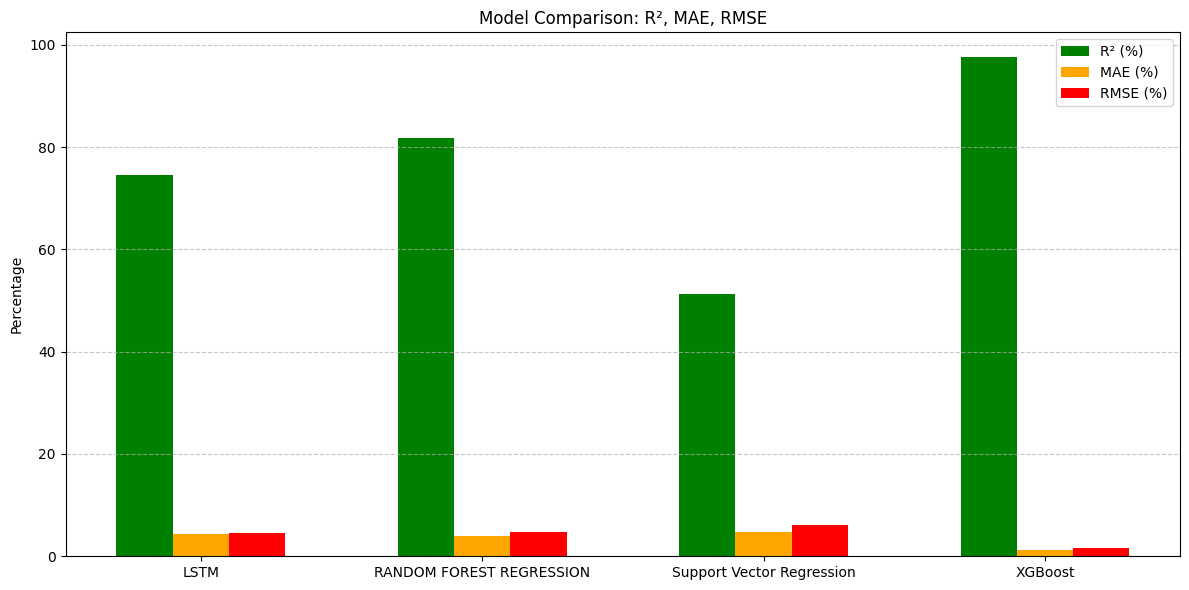

In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json

# Load model metrics
with open('model_metrics.json', 'r') as f:
    metrics = json.load(f)

# Convert to DataFrame
df = pd.DataFrame([
    {
        'Model': model,
        'R2 (%)': values['R2'],
        'MAE (%)': values['MAE'],
        'RMSE (%)': values['RMSE']
    }
    for model, values in metrics.items()
])

# Display
print("\n📊 Model Performance Comparison:")
print(df)

# Plot
bar_width = 0.2
x = np.arange(len(df['Model']))

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, df['R2 (%)'], width=bar_width, label='R² (%)', color='green')
plt.bar(x, df['MAE (%)'], width=bar_width, label='MAE (%)', color='orange')
plt.bar(x + bar_width, df['RMSE (%)'], width=bar_width, label='RMSE (%)', color='red')

plt.xticks(x, df['Model'])
plt.ylabel('Percentage')
plt.title('Model Comparison: R², MAE, RMSE')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
